SARIMA Model

Pre-processing

In [492]:
# Load pandas
import os
import pandas as pd
#import numpy as np

# Define the base directory
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, 'Hourly Energy Consumption')

# Define utilities with file names
utilities = {
    'AEP': 'AEP_hourly.csv',
    'COMED': 'COMED_hourly.csv',
    'DAYTON': 'DAYTON_hourly.csv',
    'DEOK': 'DEOK_hourly.csv',
    'DOM': 'DOM_hourly.csv',
    'DUQ': 'DUQ_hourly.csv',
    'EKPC': 'EKPC_hourly.csv',
    'FE': 'FE_hourly.csv',
    'NI': 'Ni_hourly.csv',
    'PJMW': 'PJMW_hourly.csv'
}

# Function to remove outliers
def remove_outliers(series, threshold=3):
    mean = series.mean()
    std = series.std()
    return series[(series > mean - threshold * std) & (series < mean + threshold * std)]

# Function to handle duplicate timestamps
def handle_duplicates(df, mw_col):
    # Group by index and aggregate using mean
    df = df.groupby(df.index).mean()
    return df

# Preprocess function that loads data, handles outliers, duplicates, and adds time-based features
def preprocess_data(file_path, mw_col):
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

    # Handle duplicates
    df = handle_duplicates(df, mw_col=mw_col)

    # Remove outliers
    df[mw_col] = remove_outliers(df[mw_col])

    # Drop any remaining missing values
    df.dropna(inplace=True)

    # Add time-based features: hour, day_of_week, and month
    #   pass
    
    return df

# Go over all utilities and preprocess the data
processed_data = {}
for utility, filename in utilities.items():
    file_path = os.path.join(base_dir, filename)
    df = preprocess_data(file_path, mw_col=f'{utility}_MW')
    processed_data[utility] = df


In [493]:
# sanity check on utility names
for k in processed_data:
    print(k)

AEP
COMED
DAYTON
DEOK
DOM
DUQ
EKPC
FE
NI
PJMW


In [494]:
# check data type
for utility, df in processed_data.items():
    print(utility)
    df.info()
    print()

AEP
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121010 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121010 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB

COMED
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65482 entries, 2011-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   COMED_MW  65482 non-null  float64
dtypes: float64(1)
memory usage: 1023.2 KB

DAYTON
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120572 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   DAYTON_MW  120572 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB

DEOK
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57399 entries,

In [495]:
# print data preprocessing to confirm it was done for all utilities
for utility, df in processed_data.items():
    print(f"Preprocessed data for {utility}:")
    print(df.head())

Preprocessed data for AEP:
                      AEP_MW
Datetime                    
2004-10-01 01:00:00  12379.0
2004-10-01 02:00:00  11935.0
2004-10-01 03:00:00  11692.0
2004-10-01 04:00:00  11597.0
2004-10-01 05:00:00  11681.0
Preprocessed data for COMED:
                     COMED_MW
Datetime                     
2011-01-01 01:00:00    9631.0
2011-01-01 02:00:00    9273.0
2011-01-01 03:00:00    9011.0
2011-01-01 04:00:00    8741.0
2011-01-01 05:00:00    8694.0
Preprocessed data for DAYTON:
                     DAYTON_MW
Datetime                      
2004-10-01 01:00:00     1621.0
2004-10-01 02:00:00     1536.0
2004-10-01 03:00:00     1500.0
2004-10-01 04:00:00     1434.0
2004-10-01 05:00:00     1489.0
Preprocessed data for DEOK:
                     DEOK_MW
Datetime                    
2012-01-01 01:00:00   2533.0
2012-01-01 02:00:00   2465.0
2012-01-01 03:00:00   2364.0
2012-01-01 04:00:00   2313.0
2012-01-01 05:00:00   2279.0
Preprocessed data for DOM:
                     DOM_M

In [496]:
# Load libraries

from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf

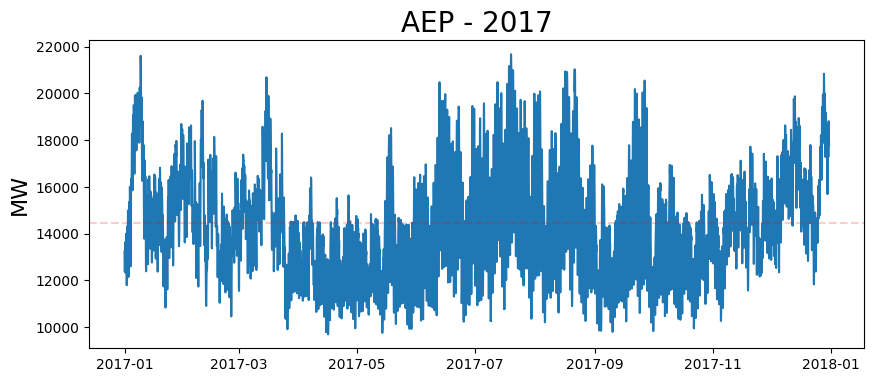

In [497]:
# plot toy dataset

start_date = datetime(2017, 1, 1)
end_date = datetime(2017, 12, 31)
df_AEP_2017 = processed_data["AEP"][start_date:end_date]

plt.figure(figsize=(10,4))
plt.plot(df_AEP_2017)
plt.title('AEP - 2017', fontsize=20)
plt.ylabel('MW', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# plot the mean
mean = df_AEP_2017["AEP_MW"].mean()
plt.axhline(mean, color='r', alpha=0.2, linestyle='--')

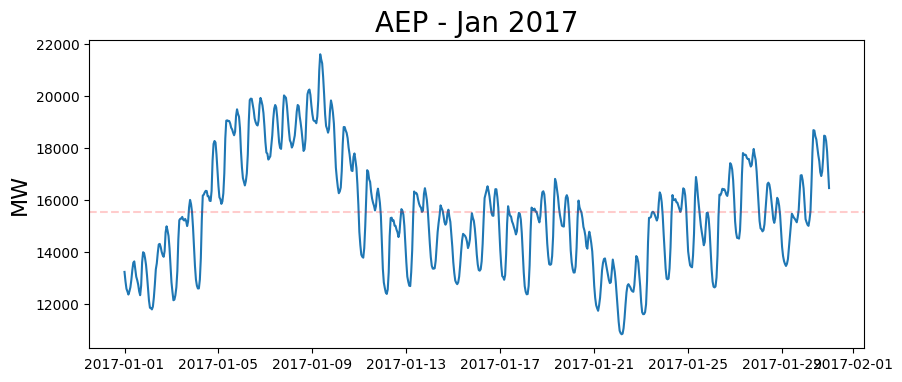

In [498]:
# plot toy dataset

start_date = datetime(2017, 1, 1)
end_date = datetime(2017, 1, 31)
df_AEP_2017_jan = processed_data["AEP"][start_date:end_date]

plt.figure(figsize=(10,4))
plt.plot(df_AEP_2017_jan)
plt.title('AEP - Jan 2017', fontsize=20)
plt.ylabel('MW', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# plot the mean
mean = df_AEP_2017_jan["AEP_MW"].mean()
plt.axhline(mean, color='r', alpha=0.2, linestyle='--')

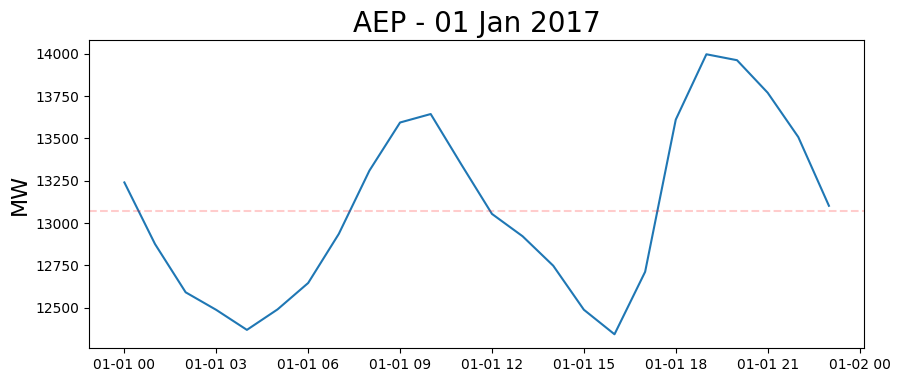

In [499]:
# plot toy dataset

start_date = datetime(2017, 1, 1, 0, 0)
end_date = datetime(2017, 1, 1, 23, 0)
df_AEP_2017_jan01 = processed_data["AEP"][start_date:end_date]

plt.figure(figsize=(10,4))
plt.plot(df_AEP_2017_jan01)
plt.title('AEP - 01 Jan 2017', fontsize=20)
plt.ylabel('MW', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# plot the mean
mean = df_AEP_2017_jan01["AEP_MW"].mean()
plt.axhline(mean, color='r', alpha=0.2, linestyle='--')

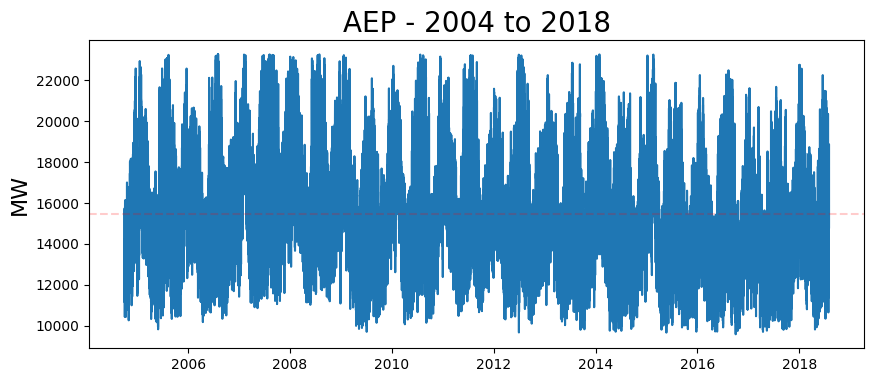

In [500]:
df_AEP = processed_data["AEP"]

plt.figure(figsize=(10,4))
plt.plot(df_AEP)
plt.title('AEP - 2004 to 2018', fontsize=20)
plt.ylabel('MW', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2, ymin=5000, ymax=25000)

# plot the mean
mean = df_AEP["AEP_MW"].mean()
plt.axhline(mean, color='r', alpha=0.2, linestyle='--')

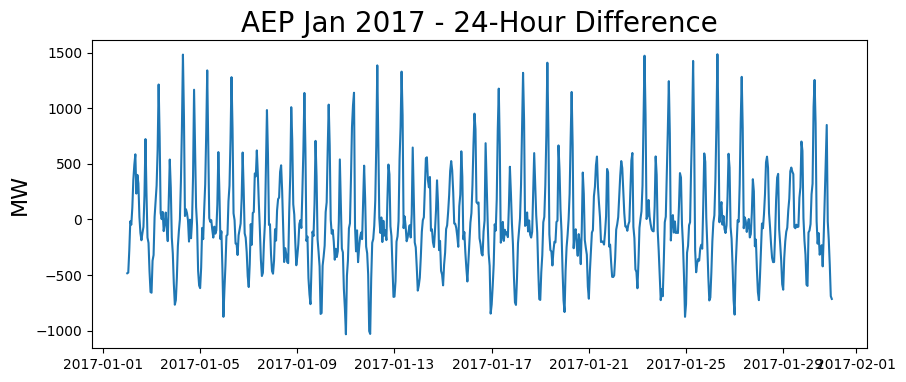

In [501]:
# daily difference

daily_diff = df_AEP_2017_jan.diff()[24:]

start_date = datetime(2017, 1, 1)
end_date = datetime(2017, 1, 31)

plt.figure(figsize=(10,4))
plt.plot(daily_diff)
plt.title('AEP Jan 2017 - 24-Hour Difference', fontsize=20)
plt.ylabel('MW', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)


<BarContainer object of 29 artists>

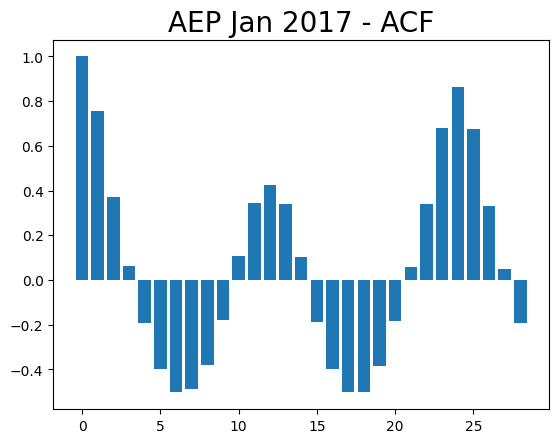

In [502]:
# ACF

acf_vals = acf(daily_diff)
num_lags = 29
plt.title("AEP Jan 2017 - ACF", fontsize=20)
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 29 artists>

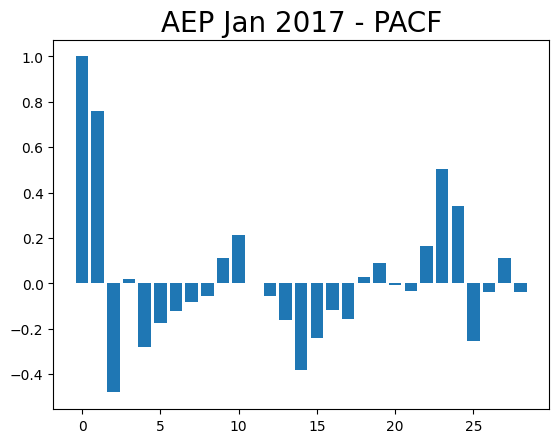

In [503]:
# PACF

pacf_vals = pacf(daily_diff)
num_lags = 29
plt.title("AEP Jan 2017 - PACF", fontsize=20)
plt.bar(range(num_lags), pacf_vals[:num_lags])

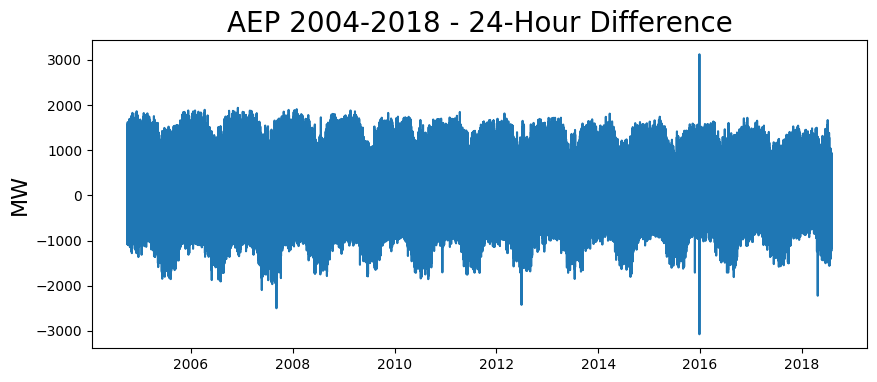

In [504]:
# daily difference - all AEP

daily_diff = df_AEP.diff()[24:]

#start_date = datetime(2017, 1, 2)
#end_date = datetime(2017, 1, 31)

plt.figure(figsize=(10,4))
plt.plot(daily_diff)
plt.title('AEP 2004-2018 - 24-Hour Difference', fontsize=20)
plt.ylabel('MW', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)


<BarContainer object of 50 artists>

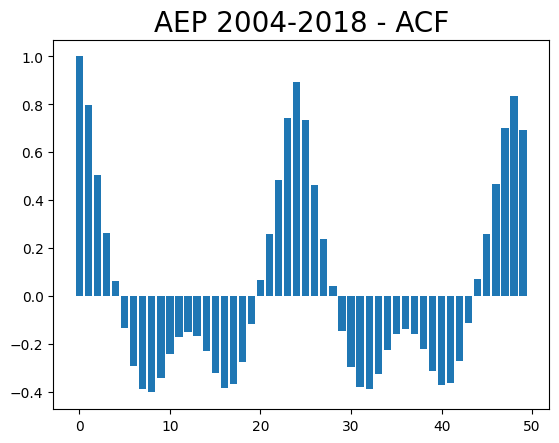

In [505]:
# ACF

acf_vals = acf(daily_diff)
num_lags = 50
plt.title("AEP 2004-2018 - ACF", fontsize=20)
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 50 artists>

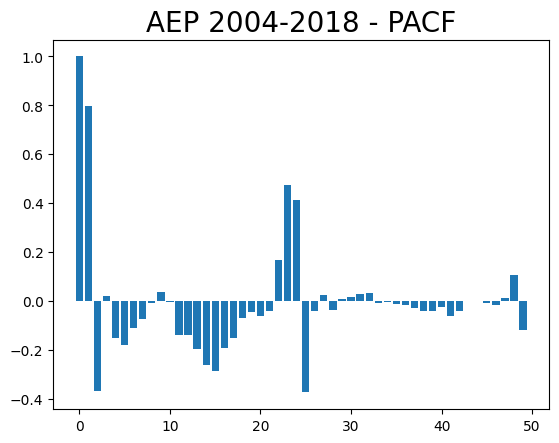

In [506]:
# PACF

pacf_vals = pacf(daily_diff)
num_lags = 50
plt.title("AEP 2004-2018 - PACF", fontsize=20)
plt.bar(range(num_lags), pacf_vals[:num_lags])

##############################################################################################

Get Training Data

In [529]:
# Train-test split: seems to be good for short-term only

df = df_AEP_2017_jan.copy(deep=True) 
#df = df_AEP_2017.copy(deep=True) 
mw_col = "AEP_MW"
df = df.asfreq(pd.infer_freq(df.index))

# Train-test split: 80% for training, 20% for testing
train_size = int(0.8 * len(df))
train_data = df[mw_col][:train_size]
test_data = df[mw_col][train_size:]

Fit SARIMA model

In [530]:
my_order = (0, 0, 0)  # AR / I / MA
my_seasonal_order = (1, 0, 1, 24)  # S / AR / I / MA

# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [531]:
# fit the model

start = time.time()
model_fit = model.fit()
end = time.time()

print('Model Fitting Time:', str(round(end - start, 2)) + " second(s)")

Model Fitting Time: 0.66 second(s)


In [532]:
# summary of the model

print(model_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:                     AEP_MW   No. Observations:                  576
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood               -4977.870
Date:                    Wed, 04 Dec 2024   AIC                           9961.739
Time:                            10:08:45   BIC                           9974.808
Sample:                        01-01-2017   HQIC                          9966.836
                             - 01-24-2017                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9939      0.004    230.298      0.000       0.985       1.002
ma.S.L24       0.2864      0.054      5.344      0.000       0.181       0.391
sigma2      1.526e+0

In [533]:
# get the predictions and residuals

predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

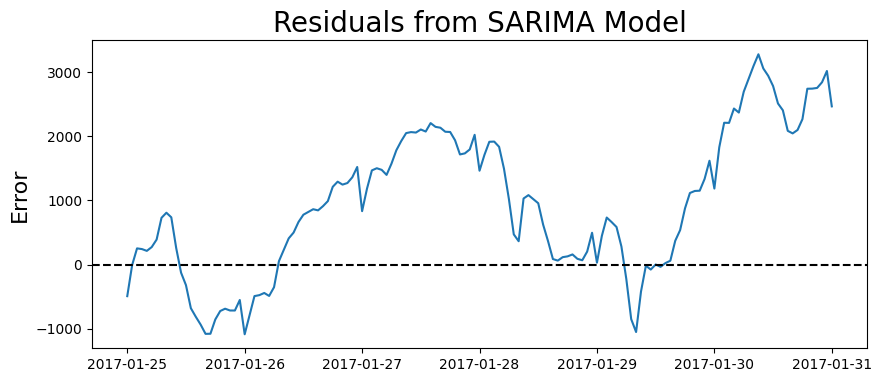

In [534]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

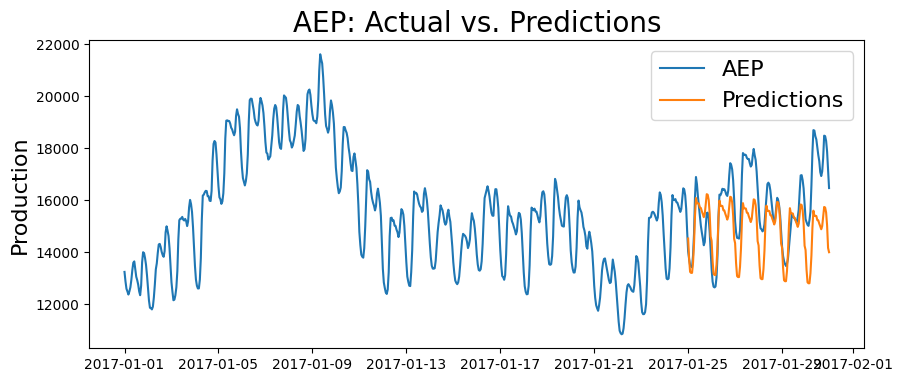

In [535]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(predictions)

plt.legend(('AEP', 'Predictions'), fontsize=16)

plt.title('AEP: Actual vs. Predictions', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [536]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0722


In [537]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1466.4915083136489


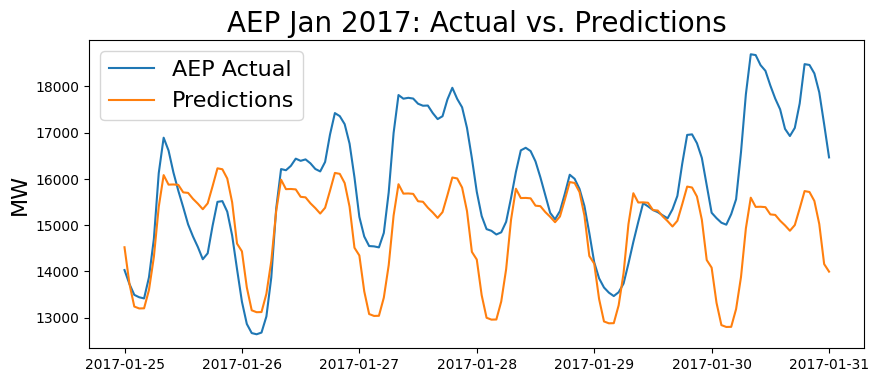

In [538]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('AEP Actual', 'Predictions'), fontsize=16)

plt.title('AEP Jan 2017: Actual vs. Predictions', fontsize=20)
plt.ylabel('MW', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

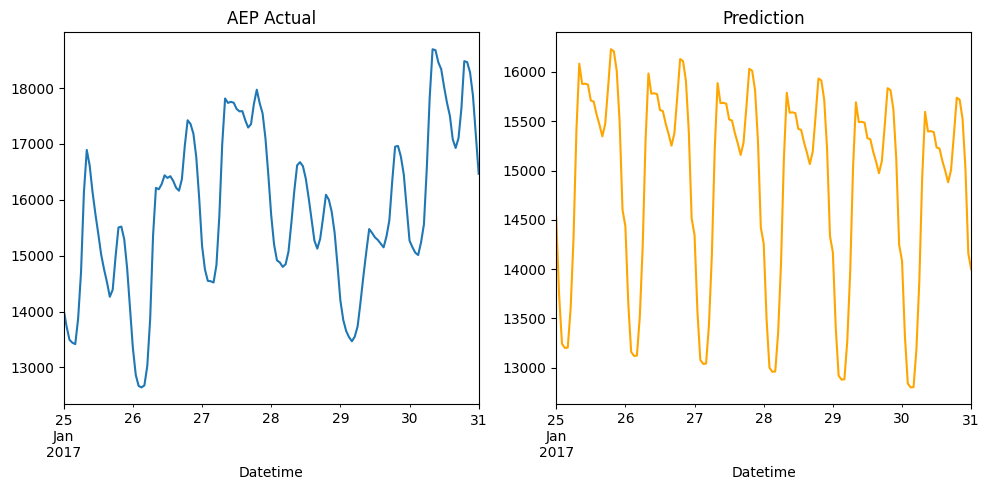

In [539]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

test_data.plot(y='AEP_MW', ax=axs[0], label='AEP')
axs[0].set_title('AEP Actual')

predictions.plot(y='AEP_MW', ax=axs[1], label='Prediction', color="orange")
axs[1].set_title('Prediction')

plt.tight_layout()
plt.show()
